# Carga de sistemas pre-entrenados en Keras


In [1]:
%load_ext autoreload
%autoreload 3

In [2]:
import os
import sys
import matplotlib.pyplot as plt

sys.path.append(os.path.dirname(os.path.abspath(os.path.abspath(""))))

In [3]:
def plot_results(history_, metric):
    history_dict = history_.history
    loss_values = history_dict["loss"]
    val_loss_values = history_dict["val_loss"]
    metric_values = history_dict[metric]
    val_metric_values = history_dict[f"val_{metric}"]

    epoch = range(1, len(loss_values) + 1)
    fig, ax = plt.subplots(1, 2, figsize=(8, 5))
    fig.suptitle("Neural Network's Result")
    ax[0].set_title("Loss function over epoch")
    ax[0].set(ylabel="loss", xlabel="epoch")
    ax[0].plot(epoch, loss_values, "go-", label="training")
    ax[0].plot(epoch, val_loss_values, "ro-", label="validation")
    ax[0].legend()

    ax[1].set_title(f"{metric} over epoch")
    ax[1].set(ylabel=metric, xlabel="epochs")
    ax[1].plot(epoch, metric_values, "go-", label="training")
    ax[1].plot(epoch, val_metric_values, "ro-", label="validation")
    ax[1].legend()
    plt.show()

## Empecemos importando las bibliotecas necesarias:


In [35]:
import tensorflow_hub as hub
from keras import Model
from keras.applications.inception_v3 import InceptionV3
from keras.callbacks import ModelCheckpoint
from keras.layers import (
    Conv2D,
    Dense,
    Dropout,
    Flatten,
    Input,
    InputLayer,
    MaxPooling2D,
)
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2

Lo más importante a resaltar aquí es que estamos usando un modelo pre-entrenado desde keras.applications en este caso InceptionV3 y que estamos importando a Modeldesde keras, este nos permitirá acceder al fucntional API de keras.

Conozcamos a [InceptionV3](https://keras.io/api/applications/inceptionv3/)


En términos sencillos nos está diciendo que el modelo fue creado con unas dimensiones de (299*299*3) y que las nuevas imágenes NO deben ser menores a 75*75 y debe ser una imagen RGB, para nuestro código ocuparemos una dimensión de (150*150\*3)

Así que lo primero que debemos hacer es modificar nuestra función get_data() para cambiar el target_size y el color_mode de las imágenes del dataset de entrenamiento, validación y prueba.


In [27]:
def get_data(target_size, color_mode):
    train_dir = "../data/rice_dataset/Train"
    test_dir = "../data/rice_dataset/Test"
    valid_dir = "../data/rice_dataset/Validation"

    _bs = 16

    train_datagen = ImageDataGenerator(rescale=1 / 255)
    test_datagen = ImageDataGenerator(rescale=1 / 255)
    valid_datagen = ImageDataGenerator(rescale=1 / 255, validation_split=0.3)

    _train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=target_size,
        batch_size=_bs,
        class_mode="categorical",
        color_mode=color_mode,
        subset="training",
    )

    _validation_generator = valid_datagen.flow_from_directory(
        valid_dir,
        target_size=target_size,
        batch_size=_bs,
        class_mode="categorical",
        color_mode=color_mode,
        subset="validation",
    )
    _test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=target_size,
        batch_size=_bs,
        class_mode="categorical",
        color_mode=color_mode,
    )

    _classes = ["Arborio", "Basmati", "Ipsala", "Jasmine", "Karacadag"]

    return _classes, _bs, _train_generator, _validation_generator, _test_generator

Perfecto, ahora nuestra función `get_data()` está parametrizada con los argumentos: `target_size`, `color_mode`

Llamamos a la función para generar los datos:


In [28]:
classes, batch_size, train_generator, validation_generator, test_generator = get_data(
    target_size=(128, 128), color_mode="rgb"
)

Found 50000 images belonging to 5 classes.
Found 3750 images belonging to 5 classes.
Found 12500 images belonging to 5 classes.


Ahora creemos una función para cargar a nuestro modelo pre-entrenado InceptionV3:


In [12]:
def load_inception_v3(shape, include_until: str):
    pretrained = InceptionV3(include_top=False, input_tensor=Input(shape=shape))
    print(pretrained.summary())

    for layer in pretrained.layers:
        layer.trainable = False

    last_layers = pretrained.get_layer(include_until)
    last_output = last_layers.output
    return pretrained, last_output

Nuestra función `load_inception_v3` por el momento tendrá únicamente 2 parámetros:

- `shape`: tamaño de las imágenes de entrenamiento, en este caso será (150x150x3)

- `include_until`: Hasta que capa de la arquitectura del modelo original deseamos incluir para usarla en nuestra nueva red.

Ahora podemos cargar el modelo al crear una instancia de la clase `InceptionV3` llamada `pretrained`, es importante decir que NO queremos incluir la capa de clasificación del modelo por eso ponemos en False al parámetro include_top. Podemos ver un resumen de la arquitectura:

El modelo es gigantesco, Tiene más de 21 Millones de parámetros entrenables, pero nosotros NO queremos reentrenar al modelo, por el contrario, queremos usar los pesos que YA conoce y aprovechar ese conocimiento adquirido en nuestro nuevo problema de clasificación. De forma sencilla lo que podemos hacer es que todas las capas de este modelo NO sean entrenables, de modo que se conservan los pesos asignados:

Excelente, hasta este momento ya tenemos un modelo fijo, pero nosotros queremos por ejemplo NO incluir el modelo completo sino hasta una cierta capa en específico, para ello debemos hacer la siguiente configuración:

```python
   for layer in pretrained.layers:
        layer.trainable = False
```

```python
last_layers = pretrained.get_layer(include_until)
```

Le estamos pidiendo al modelo que nos devuelva la capa cuya valor está en la variable `include_until` que más adelante decidiremos que el valor de está variable será `mixed7`. Ahora MUY importante, el modelo funcional, necesita operar NO directamente con las capas, sino con las salidas de las capas, es por ello que debemos asignar la salida de esta última capa:

```python
  last_output = last_layers.output
```

Hasta este momento hemos definido nuestra función load_incetion_v3 la cuál nos permite cargar el modelo completo, y también decidir desde qué capa vamos a "recortar" el modelo para añadir la nuestra:

Una simple, pero útil analogía de lo que hemos hecho hasta ahorita es la siguiente:

Podemos imaginarnos a InceptionV3 como una tira de video completa, y nuestro deber es editarla, removiendo la parte final del contenido, puesto que no la necesitamos.

Despues podemos crear nuestro propio "video" en este caso continuar con la arquitectura de nuestro nuevo modelo y finalmente unir ambas arquitecturas:

Esto es indispensable entender para manejar correctamente el `Functional API` de keras, puesto que esta herramienta no trabaja necesariamente forma secuencial, puede dar saltos de ser necesario, por eso es necesario indicar de dónde viene y a dónde va. Pero esto lo veremos más a detalle en la siguiente clase.


# API funcional de Keras

Una vez que ya hemos definido nuestra función de carga del modelo pre-entrenado es momento de definir nuestra propuesta de arquitectura nueva que utilizará transfer learning para ganar las características que ya conocía el primer modelo. Empecemos por definir una función que utilice `functional API de Keras:`


In [13]:
def functional_architecture(input_shape, n_clases):
    # Loading pretrained model
    pretrained_model, last_output = load_inception_v3(input_shape, "mixed7")

    # Attaching our new architecture
    new_architecture = Flatten()(last_output)
    new_architecture = Dense(128, activation="relu")(new_architecture)
    new_architecture = Dropout(0.2)(new_architecture)
    new_architecture = Dense(n_clases, activation="softmax")(new_architecture)

    model = Model(pretrained_model.input, new_architecture)
    print(model.summary())
    return model

Para este momento debería ser claro, que lo que estamos haciendo aquí es empezar nuestra nueva arquitectura tomando como base la arquitectura de `InceptionV3` tomando hasta la capa `mixed7`. Ahora viene la parte de adjuntarle nuestra nueva arquitectura:

```python
    # Attaching our new architecture
    new_architecture = Flatten()(last_output)
    new_architecture = Dense(128, activation="relu")(new_architecture)
    new_architecture = Dropout(0.2)(new_architecture)
    new_architecture = Dense(n_clases, activation="softmax")(new_architecture)
```

Excelente, vemos como en realidad nuestra porción de arquitectura es MUY simple, y básicamente solo está enfocada en la última etapa del modelo, la clasificación de las 5 clases que tiene nuestro problema. Podemos observar que estamos siguiendo un enfoque `Funcional` y `NO Secuencial` porque NO definimos un `model.Sequential()` y tampoco estamos añadiendo cada capa con `model.add()` si no que cada capa es una función, y estamos usando la función de una capa como entrada para una nueva capa, de esta específica forma si tiene mucha forma de `secuencial` sin embargo, veamos donde está la parte más interesante de esta `Functional API`, para poder convertir estas capas en un modelo, es necesario usar la clase `Model()` que importamos y que no habíamos utilizado antes.

```python
    model = Model(pretrained_model.input, new_architecture)
    print(model.summary())
```

Aquí estamos diciéndole a Keras que queremos crear un nuevo Modelo, cuya primer capa sea la de `pretrained_model.input` (por eso era necesario que en esta capa definiéramos el `input_shape`) y cuya última capa del modelo sea la definida en `new_architecture` la cual nosotros definimos como una cada `Dense` de clasificación.

Esta función devuelve la arquitectura de nuestro nuevo modelo, utilizando el `Functional API` y `transfer learning` pero a este punto ya es una arquitectura como las que hemos manejado en el curso, así que vamos a compilarla, entrenarla y ponerle callbacks para guardar el modelo:


In [14]:
functional_model = functional_architecture(
    input_shape=(150, 150, 3), n_clases=len(classes)
)

functional_model.compile(
    optimizer="adam", loss="categorical_crossentropy", metrics="accuracy"
)

checkpoint = ModelCheckpoint(
    filepath="../model/best_model_pre.keras",
    frecuency="epoch",
    save_weights_only=False,
    monitor="val_accuracy",
    save_best_only=True,
    verbose=1,
)

history = functional_model.fit(
    train_generator,
    epochs=2,
    validation_data=validation_generator,
    batch_size=batch_size,
    callbacks=[checkpoint],
)



87910968/87910968 [==============================] - 9s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 74, 74, 32)           864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 74, 74, 32)           96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activat

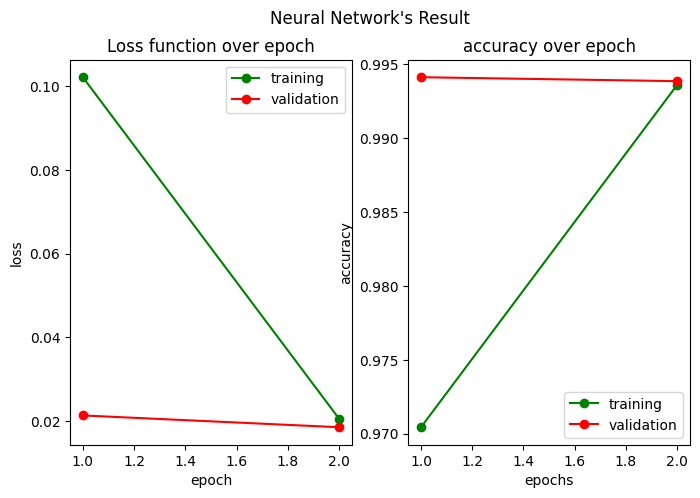

98/98 [==============================] - 34s 348ms/step - loss: 0.0159 - accuracy: 0.9947


[0.015879234299063683, 0.9947199821472168]

In [15]:
plot_results(history, "accuracy")

functional_model.evaluate(test_generator)

# sistemas pre-entrenados de TensorFlow Hub


Creo una arquitectura con base en un modelo pre-entrenado de `tensorflow hub:`


In [29]:
def hub_architecture(input_shape, n_clases, url_model):
    print("TENSOR FLOW HUB!!")

    model_hub = Sequential(InputLayer(input_shape=input_shape))

    # Una secuencia nueva
    model_hub.add(hub.KerasLayer(url_model, trainable=False))

    model_hub.add(Flatten())
    model_hub.add(Dense(128, activation="relu"))
    model_hub.add(Dropout(0.2))
    model_hub.add(Dense(n_clases, activation="softmax"))
    print("BUILD")
    # Una secuencia nueva por usar HUB de TensorFlow
    model_hub.build((None,) + input_shape)

    print(model_hub.summary())
    return model_hub

La única diferencia ahora es que agregamos una capa al modelo como: `hub.KerasLayer` ponemos como parámetro el URL del modelo que nos interesa y en esta ocasión ponemos que el modelo NO sea `trainable`, finalmente, una última diferencia es que debemos hacer un `build` del modelo antes de continuar con el proceso de compile y fit.

Vemos como a diferencia de la implementación anterior, al usar `TensorFlow HUB` todo el modelo se encuentra en una capa enorme llamada `keras_layer_1`

Finalmente, compilamos y entrenamos el modelo:


In [30]:
def fit_model(
    classes_, batch_size_, train_generator_, validation_generator_, test_generator_
):
    url = "https://www.kaggle.com/models/google/mobilenet-v1/frameworks/TensorFlow2/variations/025-128-classification/versions/2"

    h_model = hub_architecture(
        input_shape=(128, 128, 3), n_clases=len(classes_), url_model=url
    )

    h_model.compile(
        optimizer="adam", loss="categorical_crossentropy", metrics="accuracy"
    )

    history = h_model.fit(
        train_generator_,
        epochs=5,
        validation_data=validation_generator_,
        batch_size=batch_size_,
    )

    plot_results(history, "accuracy")

    h_model.evaluate(test_generator_)

TENSOR FLOW HUB!!
BUILD
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_5 (KerasLayer)  (None, 1001)              475801    
                                                                 
 flatten_3 (Flatten)         (None, 1001)              0         
                                                                 
 dense_6 (Dense)             (None, 128)               128256    
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 5)                 645       
                                                                 
Total params: 604702 (2.31 MB)
Trainable params: 128901 (503.52 KB)
Non-trainable params: 475801 (1.82 MB)
_______________________________________________________

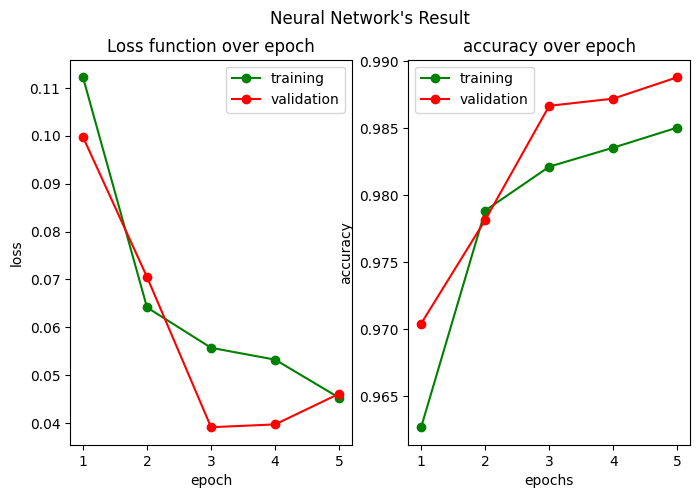

782/782 [==============================] - 8s 10ms/step - loss: 0.0401 - accuracy: 0.9898


In [31]:
fit_model(
    classes_=classes,
    batch_size_=batch_size,
    train_generator_=train_generator,
    validation_generator_=validation_generator,
    test_generator_=test_generator,
)

In [38]:
def conv_architecture(input_shape, n_clases):
    model = Sequential()
    model.add(
        Conv2D(
            filters=128, kernel_size=(3, 3), activation="relu", input_shape=input_shape
        )
    )
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(256, activation="relu", kernel_regularizer=l2(1e-5)))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation="relu", kernel_regularizer=l2(1e-5)))
    model.add(Dropout(0.2))
    model.add(Dense(n_clases, activation="softmax"))
    print(model.summary())
    return model

In [39]:
from keras.callbacks import TensorBoard
from datetime import date

Ahora generemos el modelo y añadamos el TensorBoard como un callback:


Found 50000 images belonging to 5 classes.
Found 3750 images belonging to 5 classes.
Found 12500 images belonging to 5 classes.
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 26, 26, 128)       1280      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 13, 13, 128)       0         
 g2D)                                                            
                                                                 
 flatten_6 (Flatten)         (None, 21632)             0         
                                                                 
 dense_14 (Dense)            (None, 256)               5538048   
                                                                 
 dropout_8 (Dropout)         (None, 256)               0         
                                                          

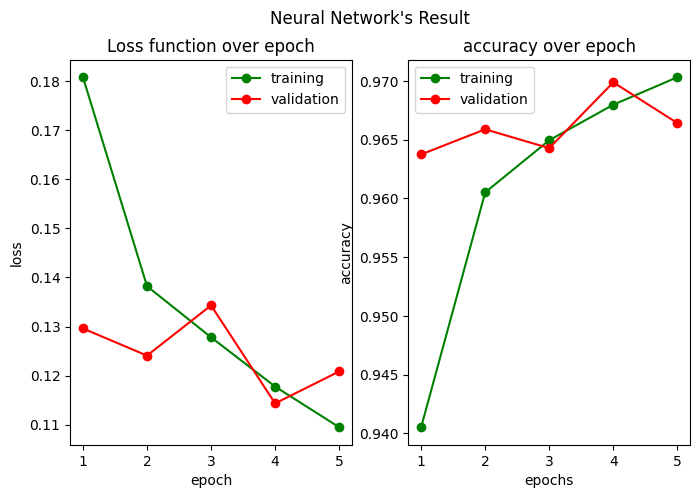

782/782 [==============================] - 5s 7ms/step - loss: 0.1053 - accuracy: 0.9711


In [42]:
classes, batch_size, train_generator, validation_generator, test_generator = get_data(
    target_size=(28, 28), color_mode="grayscale"
)

conv_model = conv_architecture(input_shape=(28, 28, 1), n_clases=len(classes))

conv_model.compile(
    optimizer="adam", loss="categorical_crossentropy", metrics="accuracy"
)

current_day = date.today().strftime("%dd_%mm_%yyyy")

tensorboard_cb = TensorBoard(log_dir=f"../logs/cnn_model_{current_day}")

history = conv_model.fit(
    train_generator,
    epochs=5,
    validation_data=validation_generator,
    batch_size=batch_size,
    callbacks=[tensorboard_cb],
)

plot_results(history, "accuracy")

results = conv_model.evaluate(test_generator)